In [339]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from sklearn import preprocessing, tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus 
from sklearn import metrics
from IPython.display import Image 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# Decision tree > Getting FUND

In [340]:
df=pd.read_json('../01_Preprocessing/First.json').sort_index()

In [341]:
df.head(2)

,country,countryCoded,degree,degreeCoded,eng,engCoded,fieldGroup,fund,gpaBachelors,gpaMasters,gre,highLevelBachUni,highLevelMasterUni,paper,targetUni,uniRank,year
2,united kingdom,4,Doctorate,1,High,1,7,TRUE,3.5,3.442986,FALSE,FALSE,FALSE,6.666667,heriot-watt,692.0,2007
3,united states,0,Doctorate,1,VeryHigh,0,5,TRUE,2.5,3.500000,TRUE,TRUE,FALSE,11.333333,northwestern,20.0,2010


In [342]:
df.columns

Index([u'country', u'countryCoded', u'degree', u'degreeCoded', u'eng',
       u'engCoded', u'fieldGroup', u'fund', u'gpaBachelors', u'gpaMasters',
       u'gre', u'highLevelBachUni', u'highLevelMasterUni', u'paper',
       u'targetUni', u'uniRank', u'year'],
      dtype='object')

In [343]:
df.uniRank.fillna(294,inplace=True)

In [344]:
df.fund= df.fund=='TRUE'
df.gre= df.gre=='TRUE'
df.highLevelBachUni= df.highLevelBachUni=='TRUE'
df.highLevelMasterUni= df.highLevelMasterUni=='TRUE'

# FUNCTIONS

In [345]:
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {"
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print "} else {"
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print "}"
                else:
                        print "return " + str(value[node])

        recurse(left, right, threshold, features, 0)

In [346]:
def build3(xtr, ytr,xte,yte,rocEnable,max_depth,criterion='entropy',class_weight=None):
    clf = DecisionTreeClassifier(criterion = criterion, random_state = 100, max_depth=max_depth,class_weight=class_weight)
    clf.fit(xtr, ytr)
    ypred = clf.predict(xte)
    if rocEnable==False:
        acc=accuracy_score(yte,ypred)*100
    else:
        fpr, tpr, thresholds = metrics.roc_curve(yte,ypred)
        acc=metrics.auc(fpr, tpr)*100
    conf=confusion_matrix(yte,ypred)
    return (clf,acc,conf)
def draw3(clf):
    dot_data = tree.export_graphviz(clf, out_file=None, feature_names=col,  max_depth=3, rounded=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    return Image(graph.create_png())  

# DTree Fund For PHD Students

In [347]:
col=['countryCoded', 'engCoded', 'fieldGroup', 'gpaBachelors','gpaMasters', 'gre', 
     'highLevelBachUni', 'highLevelMasterUni','paper','uniRank']
data=df[df.degreeCoded==1][col]
target=df[df.degreeCoded==1].fund
xtr,xte,ytr,yte=train_test_split(data,target,test_size=0.3 ,random_state=99)

In [348]:
data.head(2)

,countryCoded,engCoded,fieldGroup,gpaBachelors,gpaMasters,gre,highLevelBachUni,highLevelMasterUni,paper,uniRank
2,4,1,7,3.5,3.442986,False,False,False,6.666667,692.0
3,0,0,5,2.5,3.500000,True,True,False,11.333333,20.0


In [349]:
print(xtr.shape,ytr.shape,xte.shape,yte.shape)

((1241, 10), (1241L,), (532, 10), (532L,))


# PHD + AUC + train_test_split

In [350]:
ac=[];clfs=[]
for i in range(3,10):
    for j in range(1,10):
        for j2 in range(1,10):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                ac.append(acc)
                clfs.append(clf)

In [351]:
[max(ac),ac.index(max(ac))]

[62.07194707526493, 639]

In [352]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 9, 1: 5}, criterion='gini',
            max_depth=6, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [353]:
# draw3(clf) 

# PHD + Acc + train_test_split

In [354]:
ac=[];clfs=[]
for i in range(3,10):
    for j in range(1,10):
        for j2 in range(1,10):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                ac.append(acc)
                clfs.append(clf)

In [355]:
[max(ac),ac.index(max(ac))]

[79.323308270676691, 326]

In [356]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [357]:
# get_code(clf,col)

# PHD + Acc + train_test_split + NoWeight

In [358]:
ac=[];clfs=[]
for i in range(3,10):
    for k in ['entropy','gini']:
        clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k)
        ac.append(acc)
        clfs.append(clf)

In [359]:
[max(ac),ac.index(max(ac))]

[78.383458646616546, 5]

In [360]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [361]:
# draw3(clf)

In [362]:
# get_code(clf,col)

# PHD + AUC + StratifiedKFold

In [363]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for j in range(1,6):
                for j2 in range(1,6):
                    for k in ['entropy','gini']:
                        clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                        ac.append(acc)
                        clfs.append(clf)
                        confs.append(conf)

In [364]:
[max(ac),ac.index(max(ac))]

[71.98105081826013, 973]

In [365]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 3, 1: 2}, criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

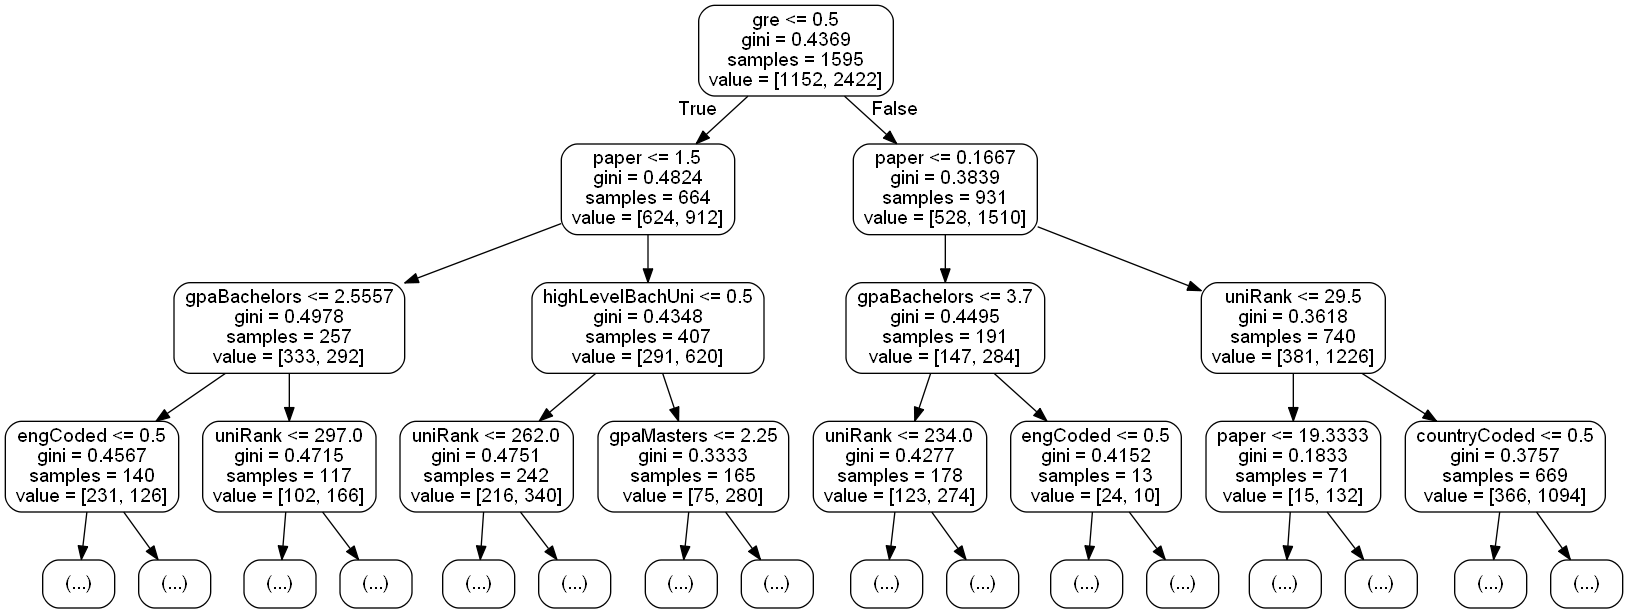

In [366]:
draw3(clf)

In [367]:
get_code(clf,col)

if ( gre <= 0.5 ) {
if ( paper <= 1.5 ) {
if ( gpaBachelors <= 2.55565452576 ) {
if ( engCoded <= 0.5 ) {
if ( gpaMasters <= 2.75 ) {
return [[ 6.  0.]]
} else {
if ( gpaMasters <= 3.47149276733 ) {
return [[  0.  16.]]
} else {
if ( highLevelBachUni <= 0.5 ) {
return [[ 6.  0.]]
} else {
return [[  6.  20.]]
}
}
}
} else {
if ( uniRank <= 406.0 ) {
if ( uniRank <= 273.0 ) {
if ( gpaBachelors <= 2.25 ) {
return [[  6.  20.]]
} else {
return [[ 30.  12.]]
}
} else {
if ( countryCoded <= 6.5 ) {
return [[ 165.   32.]]
} else {
return [[ 0.  4.]]
}
}
} else {
if ( fieldGroup <= 5.5 ) {
if ( countryCoded <= 1.5 ) {
return [[ 3.  8.]]
} else {
return [[ 9.  0.]]
}
} else {
return [[  0.  14.]]
}
}
}
} else {
if ( uniRank <= 297.0 ) {
if ( uniRank <= 284.5 ) {
if ( paper <= 0.83333337307 ) {
if ( fieldGroup <= 2.5 ) {
return [[  0.  26.]]
} else {
return [[  9.  22.]]
}
} else {
if ( paper <= 1.16666674614 ) {
return [[ 24.  16.]]
} else {
return [[  0.  12.]]
}
}
} else {
if ( highLevelBach

In [368]:
confs[ac.index(max(ac))]

array([[ 24,  19],
       [ 16, 119]])

# {0:3, 1: 2} ACC

In [369]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:3, 1: 2})
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [370]:
[max(ac),ac.index(max(ac))]

[80.337078651685388, 39]

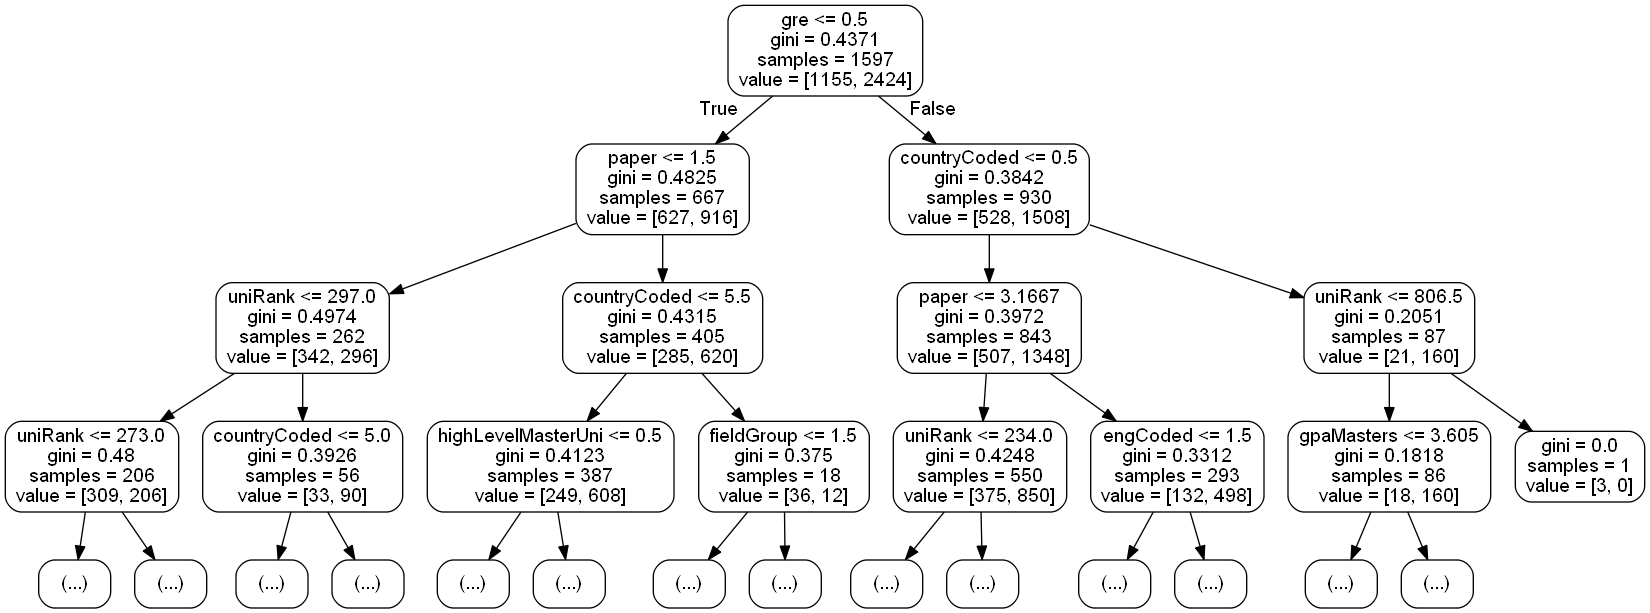

In [371]:
draw3(clf)

In [420]:
clf

DecisionTreeClassifier(class_weight={0: 3, 1: 5}, criterion='entropy',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [372]:
get_code(clf,col)

if ( gre <= 0.5 ) {
if ( paper <= 1.5 ) {
if ( uniRank <= 297.0 ) {
if ( uniRank <= 273.0 ) {
if ( uniRank <= 223.5 ) {
if ( gpaBachelors <= 3.75 ) {
if ( countryCoded <= 5.0 ) {
return [[ 72.  82.]]
} else {
return [[ 6.  0.]]
}
} else {
return [[ 0.  8.]]
}
} else {
if ( fieldGroup <= 0.5 ) {
if ( highLevelBachUni <= 0.5 ) {
return [[ 0.  2.]]
} else {
return [[ 3.  0.]]
}
} else {
return [[  0.  24.]]
}
}
} else {
if ( highLevelBachUni <= 0.5 ) {
if ( countryCoded <= 6.5 ) {
if ( gpaMasters <= 3.47149276733 ) {
return [[ 78.   6.]]
} else {
return [[ 93.  26.]]
}
} else {
return [[ 0.  4.]]
}
} else {
if ( gpaMasters <= 3.59999990463 ) {
if ( gpaBachelors <= 2.75 ) {
return [[ 33.  24.]]
} else {
return [[  0.  24.]]
}
} else {
if ( gpaBachelors <= 3.84999990463 ) {
return [[ 24.   4.]]
} else {
return [[ 0.  2.]]
}
}
}
}
} else {
if ( countryCoded <= 5.0 ) {
if ( paper <= 0.166666671634 ) {
if ( fieldGroup <= 1.5 ) {
if ( highLevelMasterUni <= 0.5 ) {
return [[ 9.  0.]]
} else {
re

# PHD + ACC + StratifiedKFold

In [373]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for j in range(1,6):
                for j2 in range(1,6):
                    for k in ['entropy','gini']:
                        clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                        ac.append(acc)
                        clfs.append(clf)
                        confs.append(conf)

In [374]:
[max(ac),ac.index(max(ac))]

[80.898876404494374, 965]

In [375]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 2, 1: 3}, criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

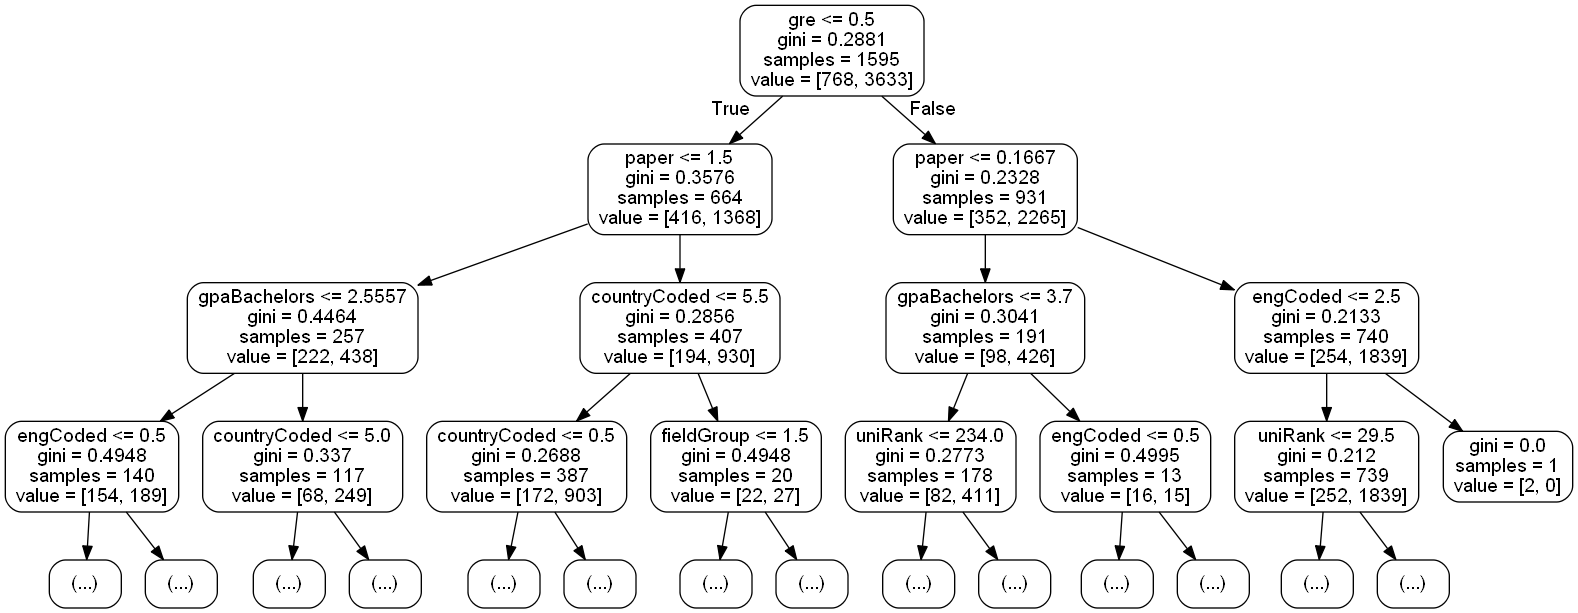

In [376]:
draw3(clf)

In [377]:
get_code(clf,col)

if ( gre <= 0.5 ) {
if ( paper <= 1.5 ) {
if ( gpaBachelors <= 2.55565452576 ) {
if ( engCoded <= 0.5 ) {
if ( gpaMasters <= 2.75 ) {
return [[ 4.  0.]]
} else {
if ( gpaMasters <= 3.47149276733 ) {
return [[  0.  24.]]
} else {
if ( highLevelBachUni <= 0.5 ) {
return [[ 4.  0.]]
} else {
return [[  4.  30.]]
}
}
}
} else {
if ( uniRank <= 406.0 ) {
if ( uniRank <= 273.0 ) {
if ( gpaBachelors <= 2.25 ) {
return [[  4.  30.]]
} else {
return [[ 20.  18.]]
}
} else {
if ( countryCoded <= 6.5 ) {
return [[ 110.   48.]]
} else {
return [[ 0.  6.]]
}
}
} else {
if ( fieldGroup <= 5.5 ) {
if ( countryCoded <= 1.5 ) {
return [[  2.  12.]]
} else {
return [[ 6.  0.]]
}
} else {
return [[  0.  21.]]
}
}
}
} else {
if ( countryCoded <= 5.0 ) {
if ( uniRank <= 297.0 ) {
if ( uniRank <= 284.5 ) {
if ( gpaMasters <= 1.75 ) {
return [[ 2.  0.]]
} else {
return [[  20.  114.]]
}
} else {
if ( highLevelBachUni <= 0.5 ) {
return [[ 28.  21.]]
} else {
return [[  8.  36.]]
}
}
} else {
if ( uniRank <= 9

In [378]:
confs[ac.index(max(ac))]

array([[ 15,  28],
       [  6, 129]])

# PHD + ACC + StratifiedKFold + BALANCED

In [379]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight="balanced")
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [380]:
[max(ac),ac.index(max(ac))]

[75.842696629213478, 0]

# PHD + AUC + StratifiedKFold + BALANCED

In [381]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight="balanced")
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [382]:
[max(ac),ac.index(max(ac))]

[68.062015503875969, 37]

# PHD + ACC + StratifiedKFold + NoWeight

In [383]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight=None)
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [384]:
[max(ac),ac.index(max(ac))]

[79.775280898876403, 46]

# PHD + AUC + StratifiedKFold + NoWeight

In [385]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==1].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight=None)
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [386]:
[max(ac),ac.index(max(ac))]

[67.278208440999137, 38]

# For Masters Students

# Masters + AUC + train_test_split

In [454]:
col=['countryCoded', 'engCoded', 'fieldGroup', 'gpaBachelors', 'gre', 'highLevelBachUni','paper','uniRank']
xtr,xte,ytr,yte=train_test_split(df[df.degreeCoded==0][col],df[df.degreeCoded==0].fund,test_size=0.2,random_state=99)

In [455]:
ac=[];clfs=[]
for i in range(3,10):
    for j in range(1,10):
        for j2 in range(1,10):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                ac.append(acc)
                clfs.append(clf)

In [456]:
[max(ac),ac.index(max(ac))]

[75.707651481645286, 650]

In [457]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 1, 1: 2}, criterion='entropy',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [458]:
# draw3(clf)

In [459]:
# get_code(clf,col)

# MASTER + ACC + train_test_split 

In [460]:
ac=[];clfs=[]
for i in range(3,10):
    for j in range(1,10):
        for j2 in range(1,10):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                ac.append(acc)
                clfs.append(clf)

In [461]:
[max(ac),ac.index(max(ac))]

[81.76638176638177, 726]

In [462]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 5, 1: 4}, criterion='entropy',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

# MASTER +AUC +StratifiedKFold

In [463]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==0].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for j in range(1,6):
                for j2 in range(1,6):
                    for k in ['entropy','gini']:
                        clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                        ac.append(acc)
                        clfs.append(clf)
                        confs.append(conf)

In [464]:
[max(ac),ac.index(max(ac))]

[83.249479528105482, 1958]

In [465]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 1, 1: 5}, criterion='entropy',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

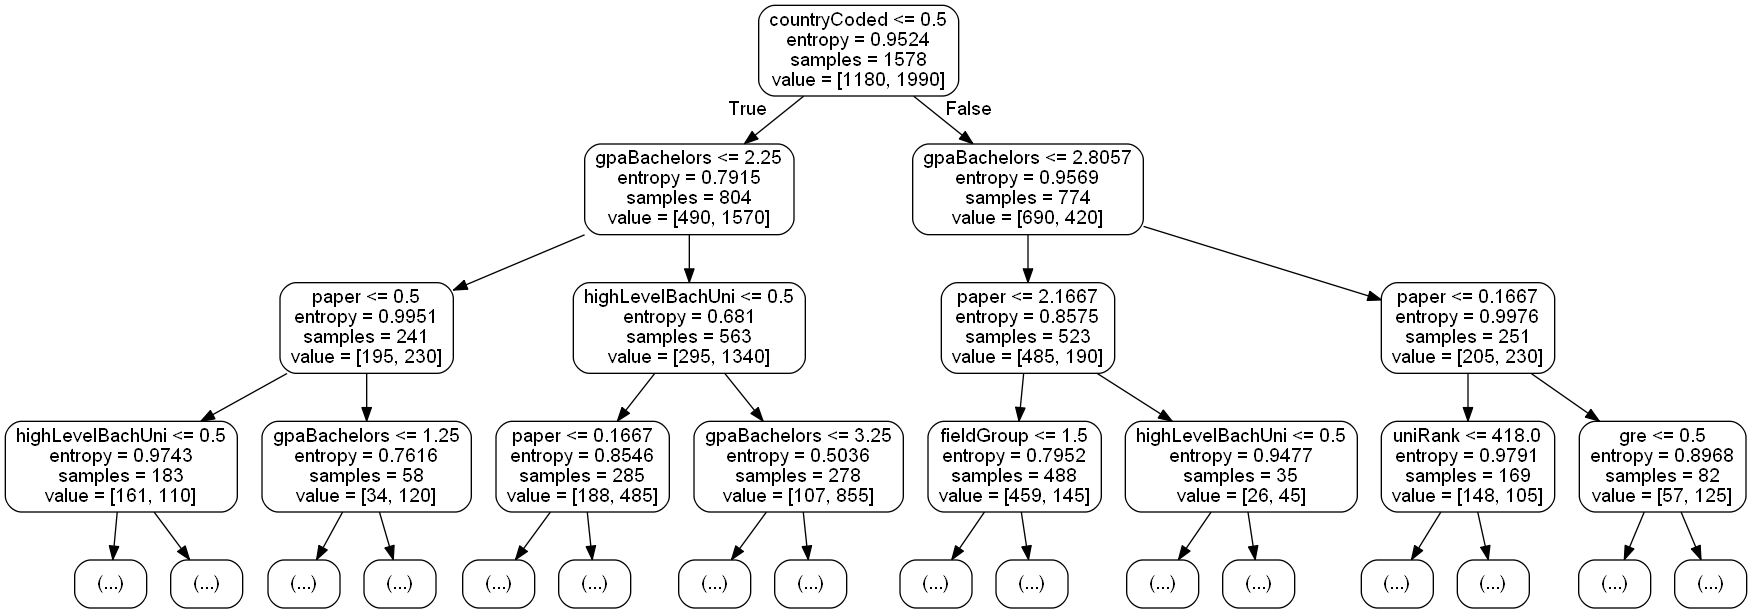

In [466]:
draw3(clf)

In [467]:
get_code(clf,col)

if ( countryCoded <= 0.5 ) {
if ( gpaBachelors <= 2.25 ) {
if ( paper <= 0.5 ) {
if ( highLevelBachUni <= 0.5 ) {
if ( engCoded <= 1.5 ) {
if ( engCoded <= 0.5 ) {
return [[ 11.   0.]]
} else {
if ( uniRank <= 241.0 ) {
return [[  6.  15.]]
} else {
return [[ 40.  20.]]
}
}
} else {
return [[ 48.   0.]]
}
} else {
if ( uniRank <= 789.5 ) {
if ( fieldGroup <= 10.5 ) {
if ( engCoded <= 0.5 ) {
return [[ 10.  30.]]
} else {
return [[ 38.  30.]]
}
} else {
return [[ 8.  0.]]
}
} else {
return [[  0.  15.]]
}
}
} else {
if ( gpaBachelors <= 1.25 ) {
return [[ 6.  0.]]
} else {
if ( uniRank <= 297.0 ) {
if ( paper <= 1.16666674614 ) {
return [[ 11.   0.]]
} else {
if ( fieldGroup <= 4.0 ) {
return [[  5.  45.]]
} else {
return [[  8.  10.]]
}
}
} else {
if ( uniRank <= 806.5 ) {
if ( paper <= 1.5 ) {
return [[  0.  40.]]
} else {
return [[  2.  25.]]
}
} else {
return [[ 2.  0.]]
}
}
}
}
} else {
if ( highLevelBachUni <= 0.5 ) {
if ( paper <= 0.166666671634 ) {
if ( uniRank <= 762.0 ) {
if (

In [468]:
confs[ac.index(max(ac))]

array([[102,  29],
       [  5,  39]])

# {0: 1, 1: 5} ACC

In [469]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==0].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:1, 1: 5})
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [470]:
[max(ac),ac.index(max(ac))]

[81.818181818181827, 16]

In [471]:
clf

DecisionTreeClassifier(class_weight={0: 1, 1: 5}, criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

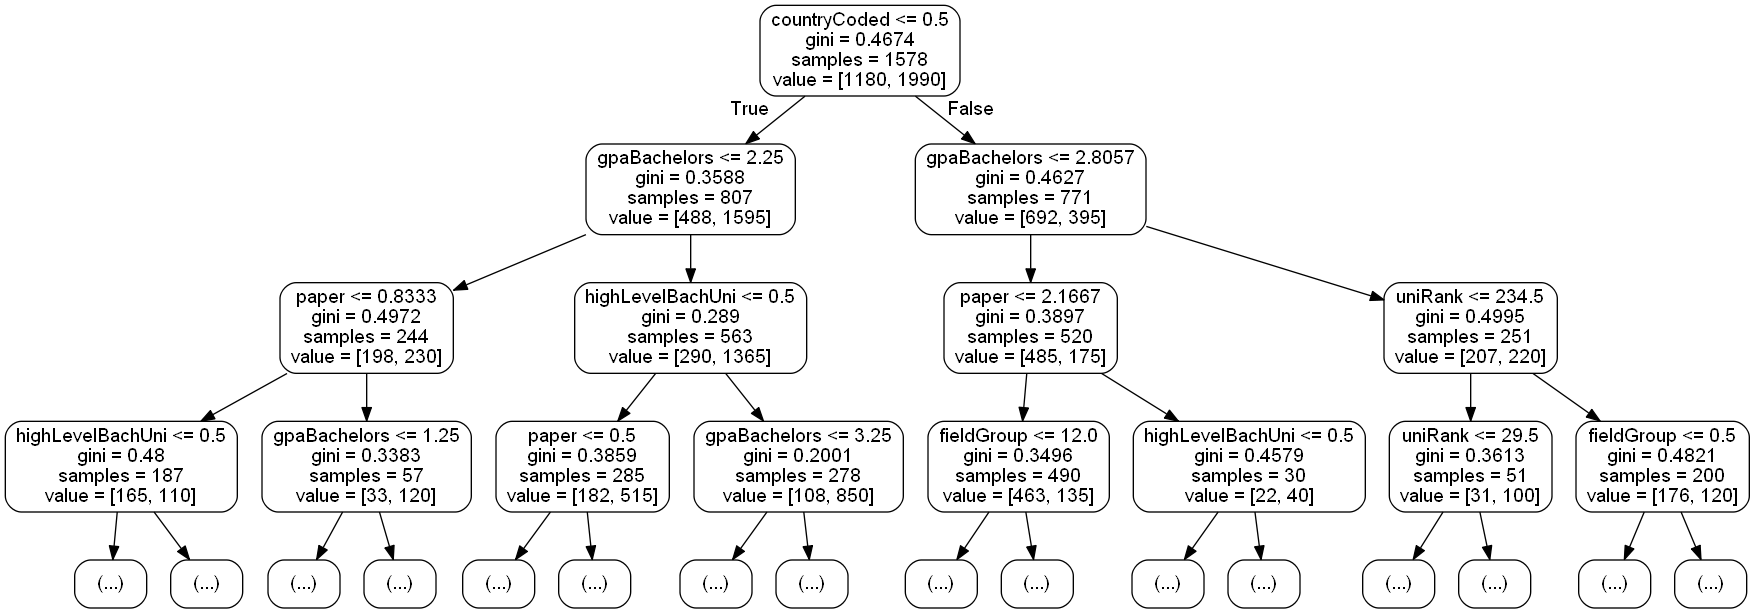

In [472]:
draw3(clf)

In [473]:
get_code(clf,col)

if ( countryCoded <= 0.5 ) {
if ( gpaBachelors <= 2.25 ) {
if ( paper <= 0.83333337307 ) {
if ( highLevelBachUni <= 0.5 ) {
if ( engCoded <= 1.5 ) {
if ( uniRank <= 241.0 ) {
if ( gre <= 0.5 ) {
return [[ 8.  5.]]
} else {
return [[  0.  15.]]
}
} else {
if ( paper <= 0.166666671634 ) {
return [[ 44.  10.]]
} else {
return [[ 11.  10.]]
}
}
} else {
return [[ 45.   0.]]
}
} else {
if ( fieldGroup <= 6.0 ) {
if ( gre <= 0.5 ) {
if ( uniRank <= 309.0 ) {
return [[ 15.   0.]]
} else {
return [[  2.  10.]]
}
} else {
if ( engCoded <= 0.5 ) {
return [[  3.  30.]]
} else {
return [[ 11.  20.]]
}
}
} else {
if ( uniRank <= 721.5 ) {
return [[ 24.   0.]]
} else {
if ( gre <= 0.5 ) {
return [[  0.  10.]]
} else {
return [[ 2.  0.]]
}
}
}
}
} else {
if ( gpaBachelors <= 1.25 ) {
return [[ 4.  0.]]
} else {
if ( uniRank <= 297.0 ) {
if ( paper <= 1.16666674614 ) {
return [[ 11.   0.]]
} else {
if ( fieldGroup <= 4.0 ) {
return [[  4.  50.]]
} else {
return [[  9.  10.]]
}
}
} else {
if ( uniRank 

# MASTER +AUC +StratifiedKFold + BALANCED

In [474]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==0].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=True,max_depth=i,criterion=k,class_weight="balanced")
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [475]:
[max(ac),ac.index(max(ac))]

[81.919191919191917, 3]

# MASTER +ACC +StratifiedKFold + BALANCED

In [476]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==0].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for k in ['entropy','gini']:
                clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight="balanced")
                ac.append(acc)
                clfs.append(clf)
                confs.append(conf)

In [477]:
[max(ac),ac.index(max(ac))]

[82.954545454545453, 14]

# MASTER +ACC +StratifiedKFold

In [478]:
ac=[];clfs=[];confs=[]
dfTemp=df[df.degreeCoded==0].reset_index(drop=True)
for spl in range(10,11):
    skf = StratifiedKFold(n_splits=spl)
    for train,test in skf.split(dfTemp[col], dfTemp.fund):
        xtr, ytr,xte,yte=dfTemp.ix[train][col],dfTemp.ix[train]['fund'],dfTemp.ix[test][col],dfTemp.ix[test]['fund']
        for i in range(3,8):
            for j in range(1,6):
                for j2 in range(1,6):
                    for k in ['entropy','gini']:
                        clf,acc,conf=build3(xtr, ytr,xte,yte,rocEnable=False,max_depth=i,criterion=k,class_weight={0:j, 1: j2})
                        ac.append(acc)
                        clfs.append(clf)
                        confs.append(conf)

In [479]:
[max(ac),ac.index(max(ac))]

[85.227272727272734, 378]

In [480]:
clf=clfs[ac.index(max(ac))]
clf

DecisionTreeClassifier(class_weight={0: 3, 1: 5}, criterion='entropy',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [481]:
# draw3(clf)

In [482]:
confs[ac.index(max(ac))]

array([[123,   8],
       [ 18,  27]])

In [483]:
# get_code(clf,col)

## Sample Path

In [484]:
# col=['countryCoded', 'engCoded', 'fieldGroup', 'gpaBachelors', 'gre', 
#      'highLevelBachUni','paper','uniRank']
me=[1,2,0,3.1,False,False,1,100]
clf.decision_path([me]).toarray()

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [485]:
clf.predict([me])

array([False], dtype=bool)

In [486]:
clf.classes_

array([False,  True], dtype=bool)

In [487]:
clf.predict_proba([me])

array([[ 0.5,  0.5]])